# Transfer Learning on Fashion MNIST
---

## Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import torch
import torchvision

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Global Configs

In [4]:
size = 224
DATAPATH = "../data/FashionMNIST/"

In [5]:
is_sample = False
if is_sample: PATH = DATAPATH+'sample'
else: PATH = DATAPATH

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.backends.cudnn.enabled

True

## Load Dataset

In [8]:
data = torchvision.datasets.FashionMNIST(DATAPATH,
                                         download=True)

In [9]:
test = torchvision.datasets.FashionMNIST(DATAPATH,
                                         train=False)

## Data Exploration

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Let's look at the class distribution...

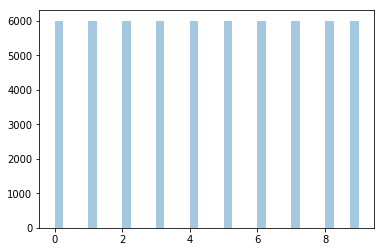

In [10]:
sns.distplot(data.train_labels,kde=False)

We find an equal distribution for all classes i.e. 6000 for all 10 fashion classes

Let's look at the images...

In [11]:
def plot_images(imgs, figsize=(12,6), titles=None, maintitle=None):
    fig = plt.figure(figsize=figsize)
    imgs = np.array(imgs)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=16)
    imgs_len = len(imgs)
    for idx in range(imgs_len):
        subplt = fig.add_subplot(1, imgs_len, idx+1)
        subplt.axis('Off')
        if titles is not None:
            subplt.set_title(titles[idx], fontsize=16)
        plt.imshow(imgs[idx], cmap='gray')

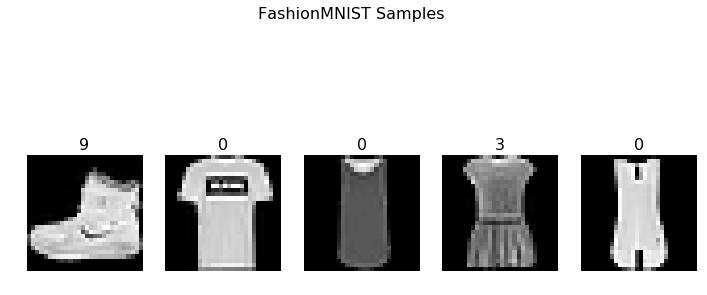

In [12]:
plot_images(data.train_data[:5],
            titles=data.train_labels[:5],
            maintitle='FashionMNIST Samples')

In [13]:
data.train_data.shape

torch.Size([60000, 28, 28])

Hence, we have 60,000 images of dimensions 28 by 28

In [14]:
labels_dict = {0: 'Top', 1: 'Trouser', 2: 'Pullover', 
               3: 'Dress', 4: 'Coat', 5: 'Sandal',
               6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Boot'}

## Data Preprocessing

Here we split the dataset into sample_train, sample_valid, train and valid sets.

Sample dataset is for testing on local machine before training on the cloud. It is set by the global config SAMPLE.

In [14]:
# sample_train = data.train_data[:1000]
# sample_train_labels = data.train_labels[:1000]
# sample_valid = data.train_data[1000:1100]
# sample_valid_labels = data.train_labels[1000:1100]

In [18]:
train = data.train_data[:50000]
train_labels = data.train_labels[:50000]
valid = data.train_data[50000:60000]
valid_labels = data.train_labels[50000:60000]

Create data directory structure

In [19]:
os.mkdir(DATAPATH+'train')
os.mkdir(DATAPATH+'valid')

In [82]:
# a sample of the dataset
# os.mkdir(DATAPATH+'sample/train')
# os.mkdir(DATAPATH+'sample/valid')

Populate data directories

In [20]:
def imwrite_dir(images, labels, path):
    # make directory structure for labels or classes
    for label in np.unique(labels):
        os.mkdir(path+str(label))
    # put the images in the proper label directories
    for i in range(images.shape[0]):
        image = images[i]
        filepath = path+str(labels[i])+'/'+str(i)+'.jpg'
        torchvision.utils.save_image(image,
                                     filepath)

In [22]:
# imwrite_dir(sample_train, sample_train_labels, DATAPATH+'sample/train/')
# imwrite_dir(sample_valid, sample_valid_labels, DATAPATH+'sample/valid/')


In [23]:
imwrite_dir(train, train_labels, DATAPATH+'train/')
imwrite_dir(valid, valid_labels, DATAPATH+'valid/')

**Sanity check for data distribution**

In [27]:
! ls ../data/FashionMNIST/train/0 | wc -l
! ls ../data/FashionMNIST/train/1 | wc -l
! ls ../data/FashionMNIST/train/5 | wc -l
! ls ../data/FashionMNIST/train/9 | wc -l

4977
5012
5004
4979


In [28]:
! ls ../data/FashionMNIST/valid/0 | wc -l
! ls ../data/FashionMNIST/valid/1 | wc -l
! ls ../data/FashionMNIST/valid/5 | wc -l
! ls ../data/FashionMNIST/valid/9 | wc -l

1023
988
996
1021


## Training Model [resnet34]

In [15]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH,tfms=tfms_from_model(arch, size))

In [16]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 157/157 [00:54<00:00,  2.90it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.578045   0.45962    0.831111  
    1      0.529723   0.428042   0.84365                     



[0.42804232, 0.8436504777070064]

In [17]:
learn.save('resnet34-sample')

## Model Analysis

In [18]:
learn.load('resnet34-sample')

In [19]:
log_preds=learn.predict()
log_preds.shape

(10000, 10)

In [20]:
log_preds[:5]

array([[ -0.29578,  -9.36903,  -5.51021,  -2.85462,  -4.4797 , -10.25824,  -1.70221, -11.50775,  -7.32372,
        -10.91317],
       [ -0.01886,  -7.85496,  -5.27928,  -5.37341,  -8.36146, -11.81864,  -4.82269, -13.62728,  -8.22094,
        -12.1246 ],
       [ -0.02987, -10.38537,  -7.208  ,  -5.29618,  -7.77316,  -4.88767,  -4.17391,  -9.90188,  -8.52827,
        -10.03786],
       [ -0.01625,  -9.03265,  -7.83179,  -7.29684,  -8.29942, -10.0825 ,  -4.22699, -13.49936, -10.40507,
        -13.13357],
       [ -0.00433, -11.06808,  -7.24283,  -7.87958, -10.40725, -13.3574 ,  -5.75843, -14.61298, -10.56534,
        -15.9508 ]], dtype=float32)

In [25]:
preds = np.argmax(log_preds, axis=1)
preds[-5:]

array([3, 9, 9, 9, 9])

In [26]:
all_probs = {}
for key, label in labels_dict.items():
    all_probs[key] = np.exp(log_preds[:,key])

** Analysis Utilities**

In [27]:
# def rand_by_correct(is_correct=True):
#     mask = ((preds == data.val_y) == is_correct)
#     sample_idx = np.random.choice(np.where(mask)[0],
#                                   4, replace=True)
#     return sample_idx

# def most_by_correct(y, is_correct=True):
#     mask = np.where((preds == data.val_y)==is_correct
#                     & (y==data.val_y))[0]
#     sorted_idx = np.argsort(probs[mask, y])
#     return sorted_idx

def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y)==is_correct)

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct)
                        & (data.val_y == y), mult)

** Plot Utilities **

In [28]:
# def plots(ims, figsize=(12,6), rows=1, titles=None):
#     f = plt.figure(figsize=figsize)
#     for i in range(len(ims)):
#         sp = f.add_subplot(rows, len(ims)//rows, i+1)
#         sp.axis('Off')
#         if titles is not None: sp.set_title(titles[i], fontsize=20)
#         plt.imshow(ims[i])
        
# def load_img_id(ds, idx):
#     return np.array(PIL.Image.open(PATH+'/'+ds.fnames[idx]))

# def plot_val_with_title(idxs, title, is_correct=True):
#     imgs = [load_img_id(data.val_ds,x) for x in idxs]
#     title_probs = [np.round(probs[x], 4) for x in idxs]
#     if is_correct:
#         title_class = np.argmax(title_probs, axis=1)
#     else:
#         title_class = np.argmin(title_probs, axis=1)
#     print(title)
#     return plots(imgs, rows=1, titles=title_class, figsize=(16,8))

In [29]:
def plots(ims, figsize=(12,6), rows=1, titles=None, main_title=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
    plt.suptitle(main_title, fontsize=24)


In [30]:
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+'/'+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    return plots(imgs, rows=1, titles=title_probs,
                 figsize=(16,8), main_title=title)

### A few correct labels at random

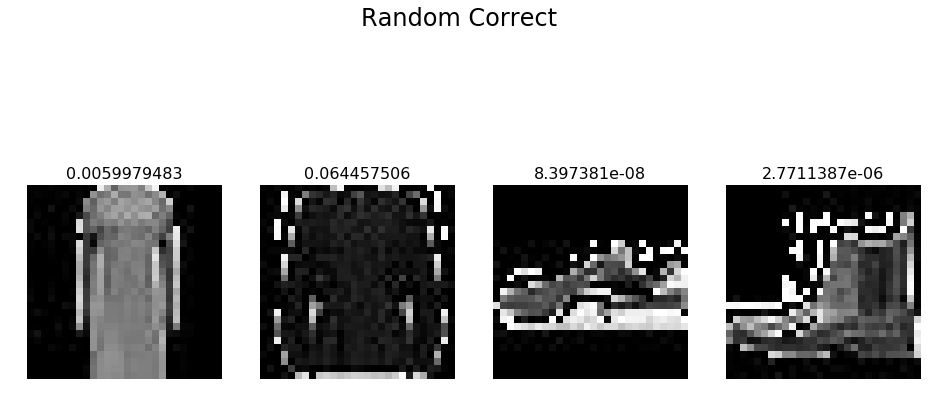

In [31]:
correct_idx = rand_by_correct(is_correct=True)
probs = all_probs[0]
plot_val_with_title(correct_idx, "Random Correct")

### A few incorrect labels at random

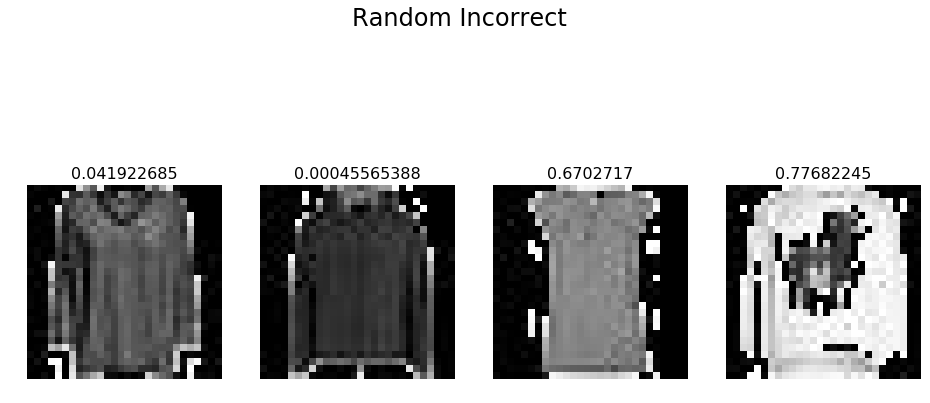

In [32]:
incorrect_idx = rand_by_correct(is_correct=False)
probs = all_probs[0]
plot_val_with_title(incorrect_idx, "Random Incorrect")

** The most correct labels of each class**

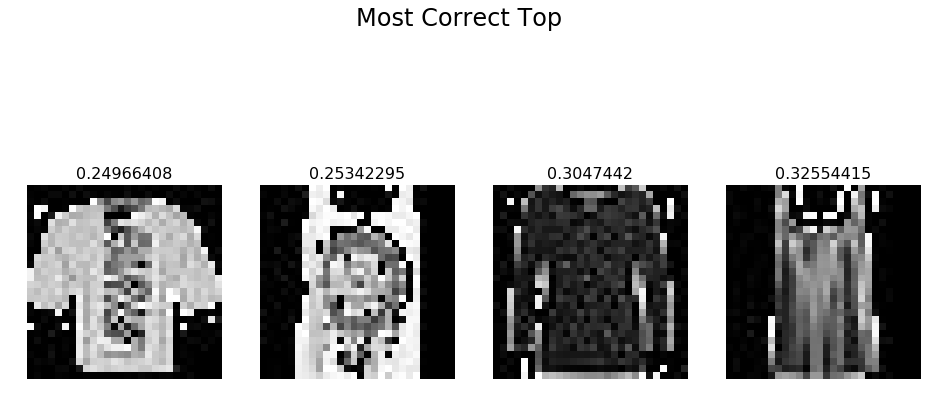

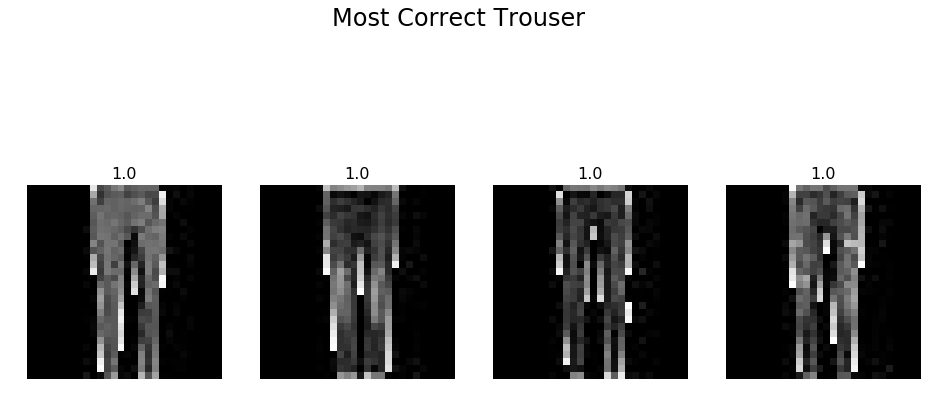

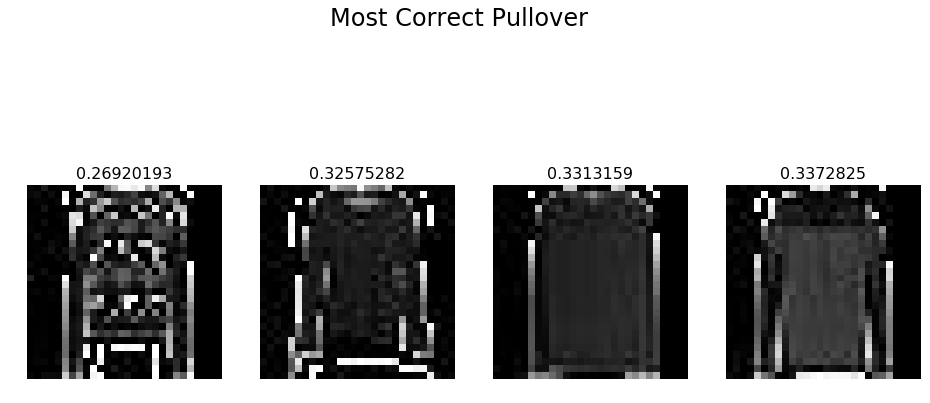

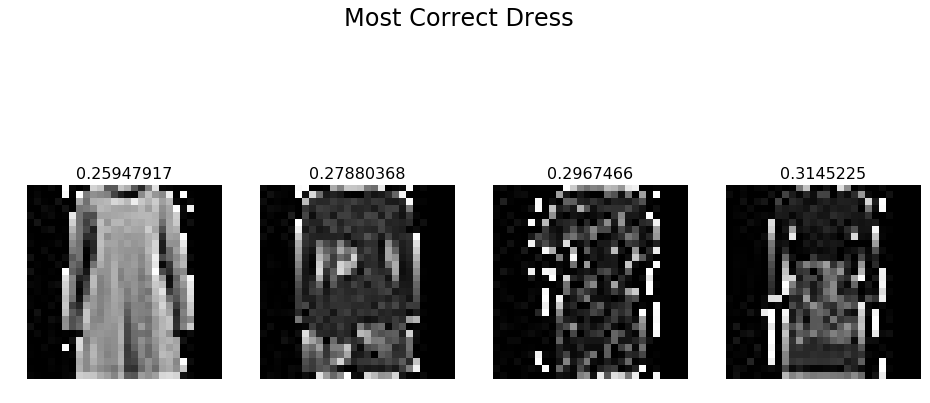

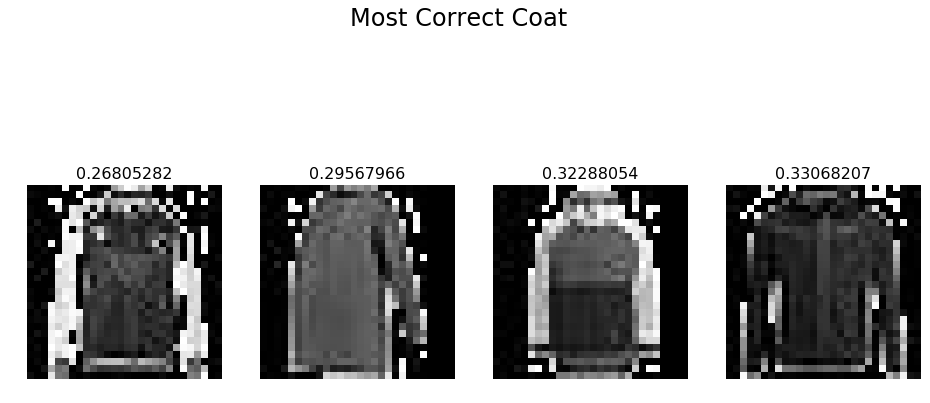

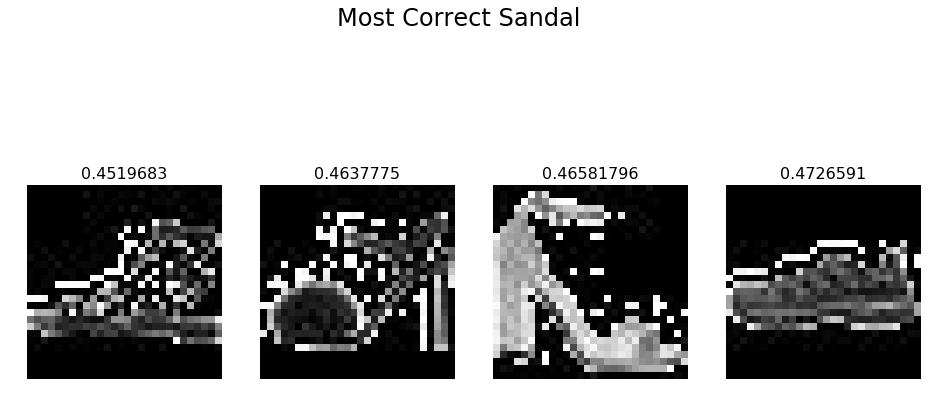

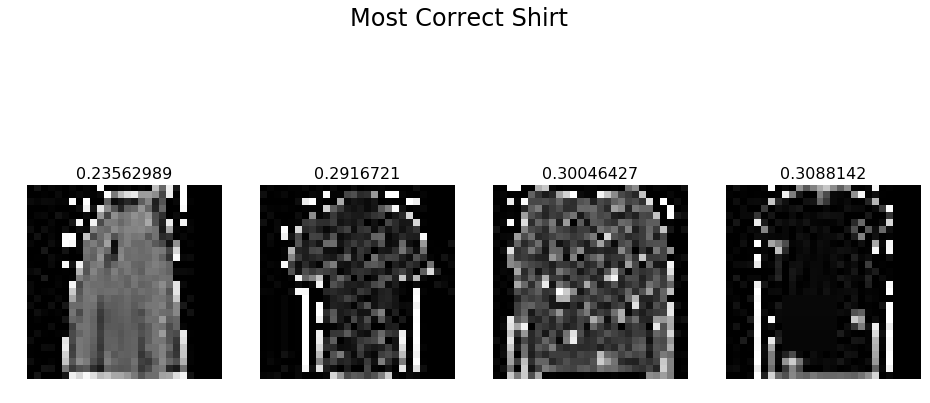

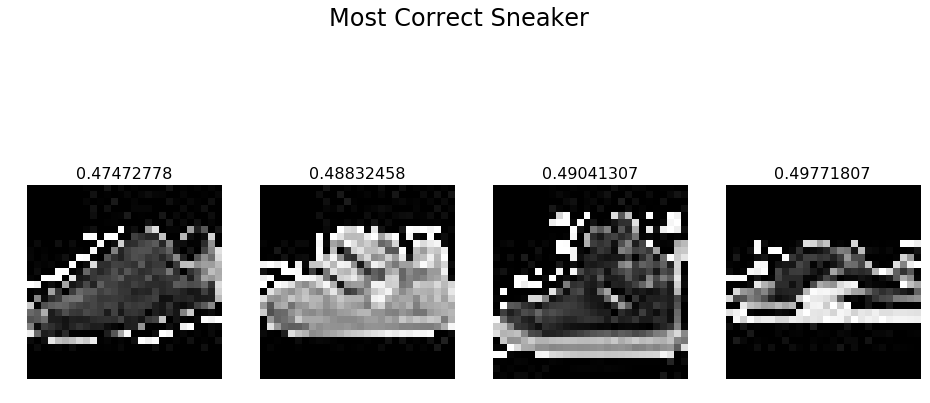

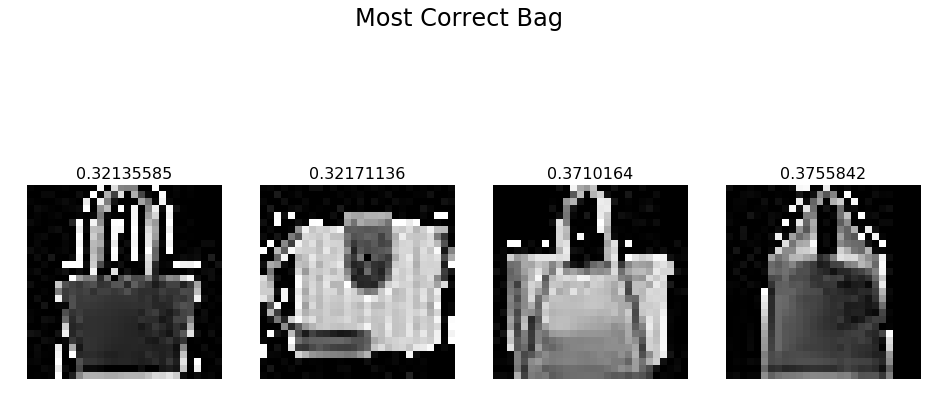

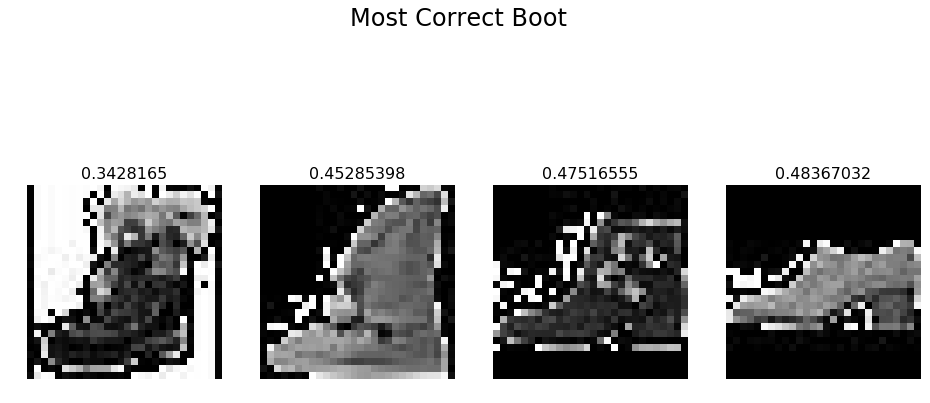

In [33]:
for key, label in labels_dict.items():
    probs=all_probs[key]
    plot_val_with_title(most_by_correct(key, True),
                        "Most Correct {}".format(label))

### TODO: The most incorrect labels of each class

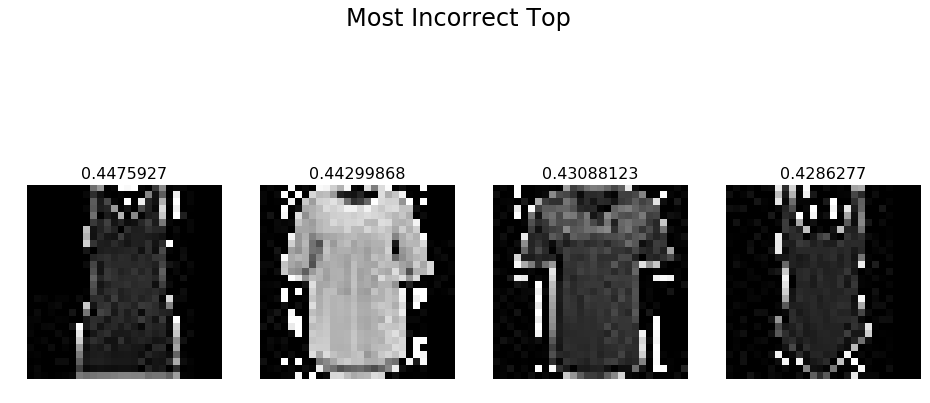

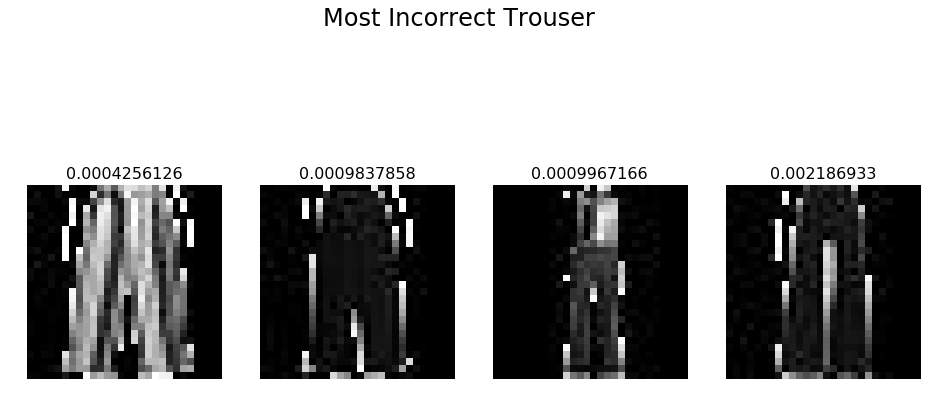

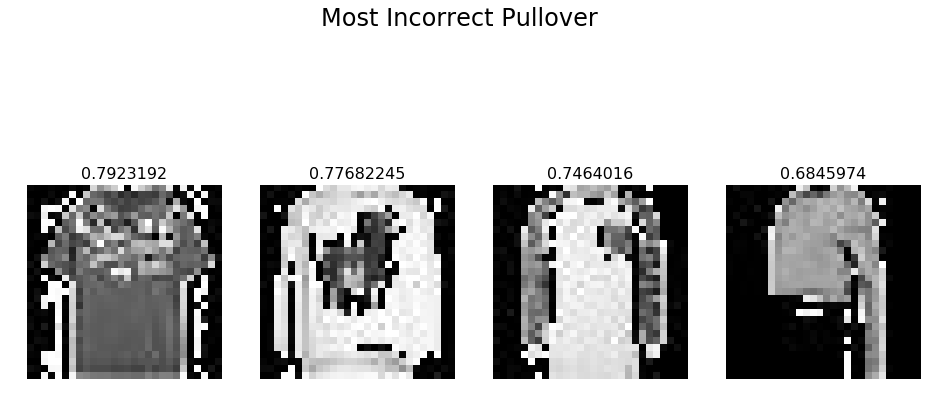

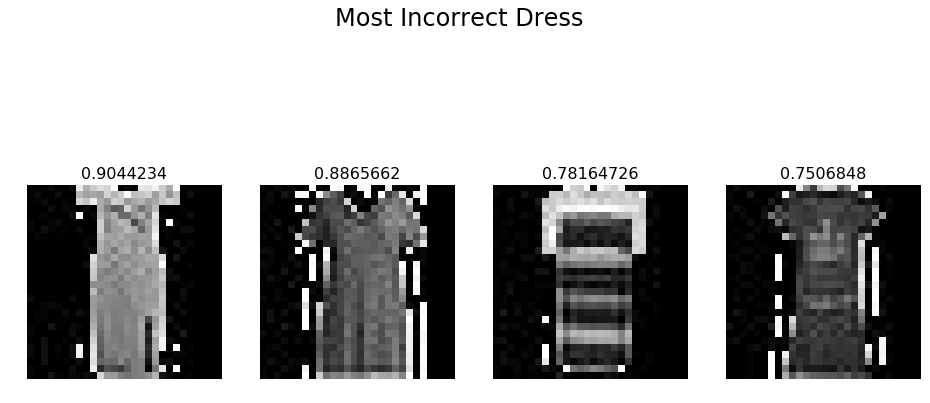

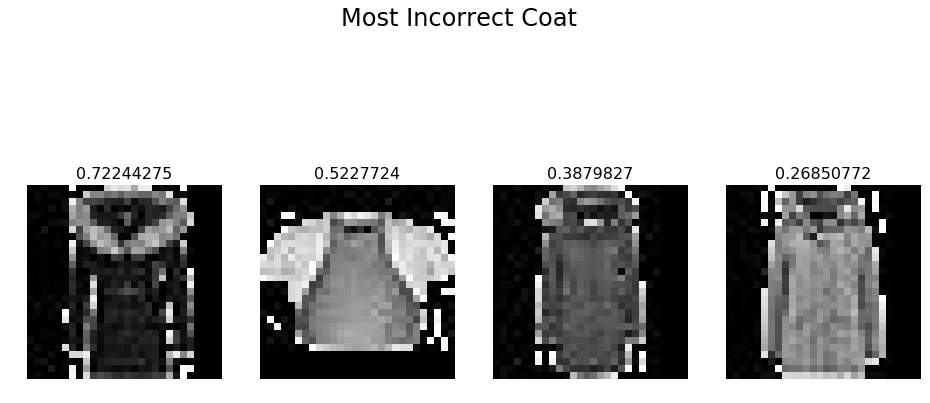

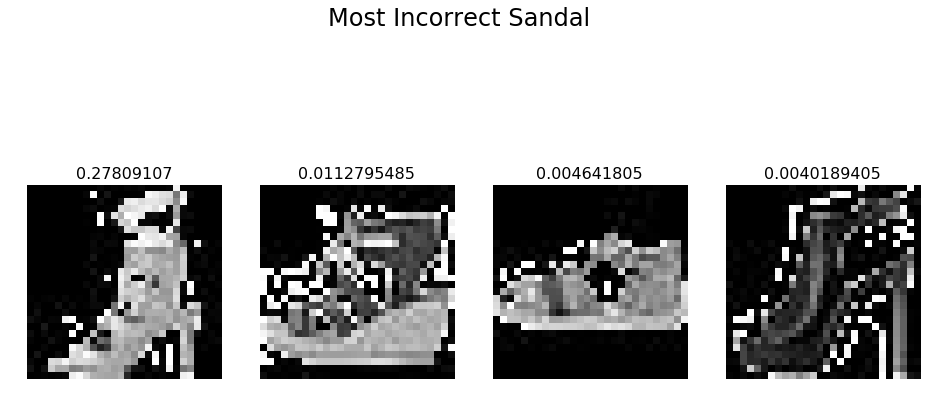

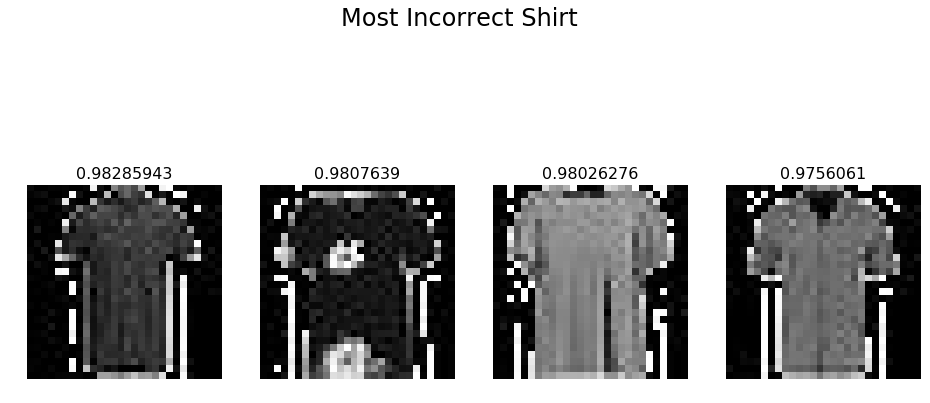

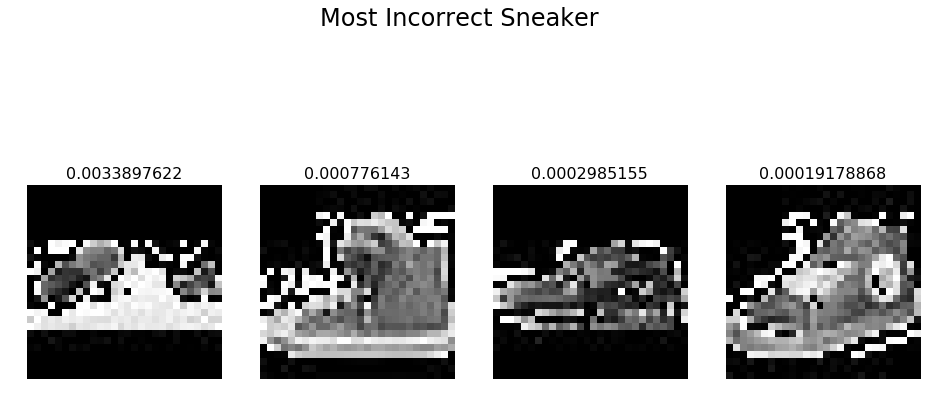

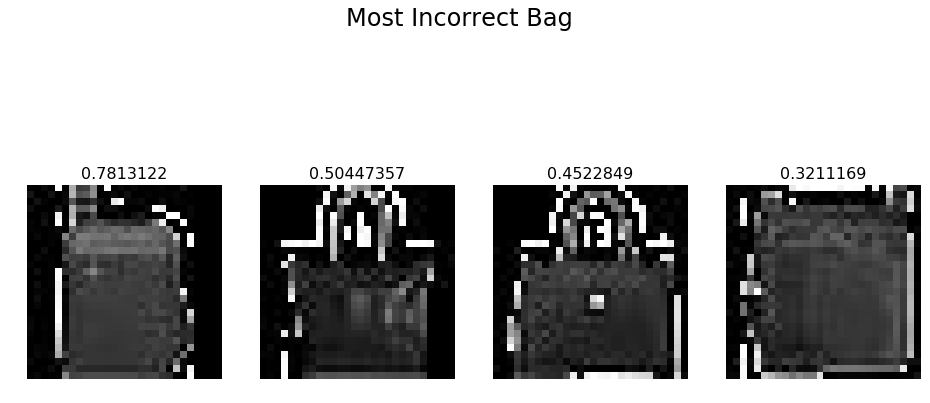

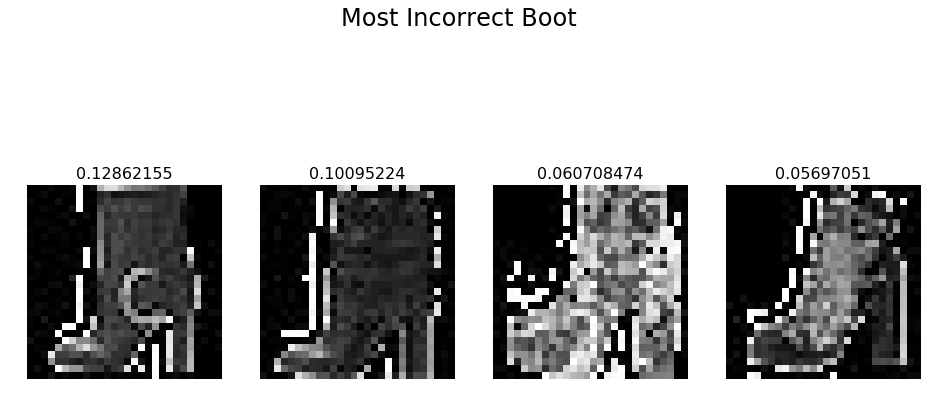

In [34]:
for key, label in labels_dict.items():
    probs=all_probs[0]
    plot_val_with_title(most_by_correct(key, False),
                        "Most Incorrect {}".format(label))

## The most uncertain labels for each class

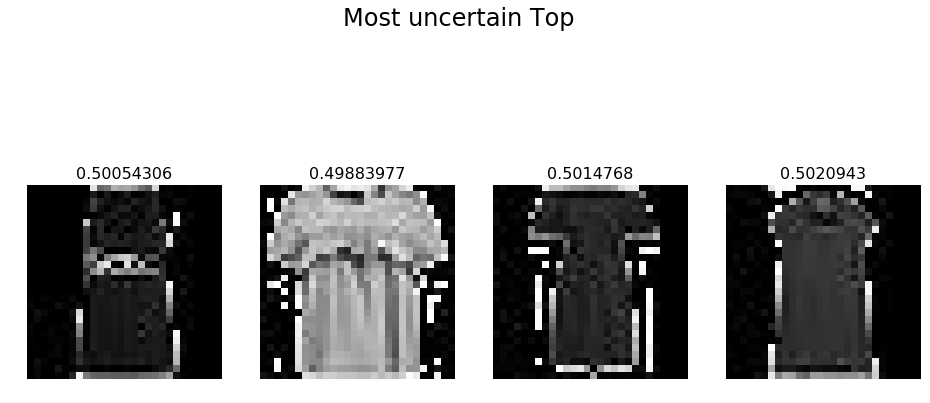

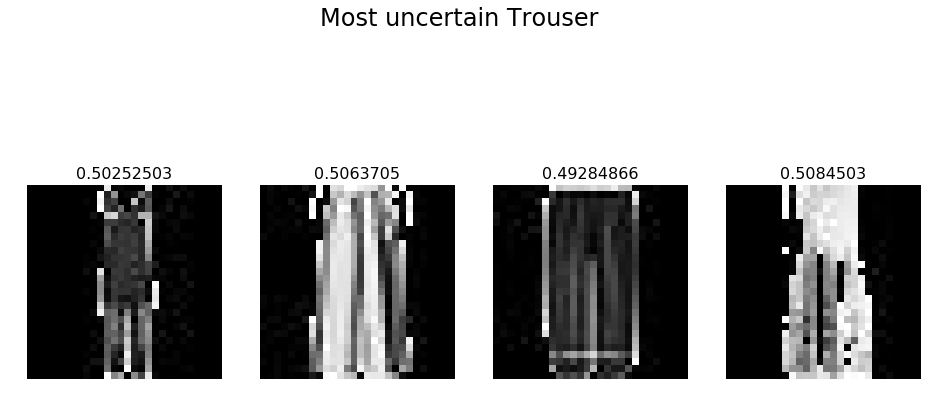

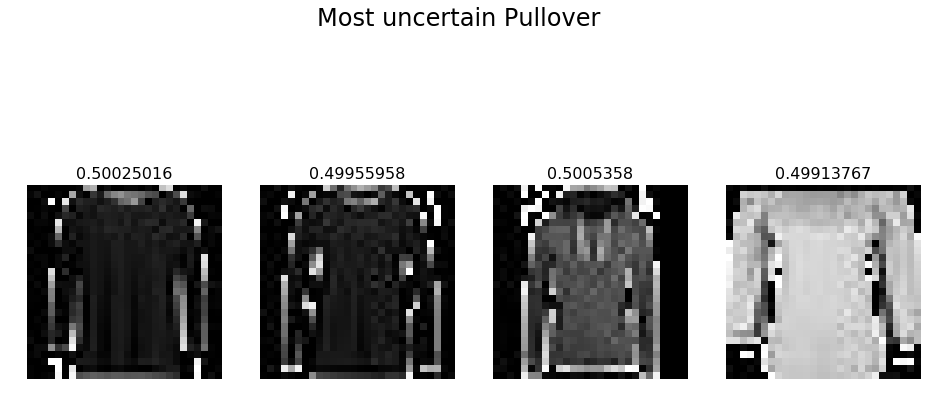

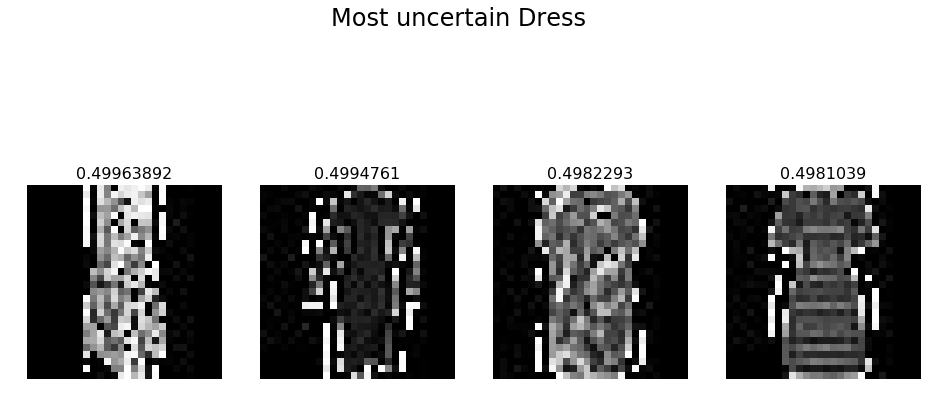

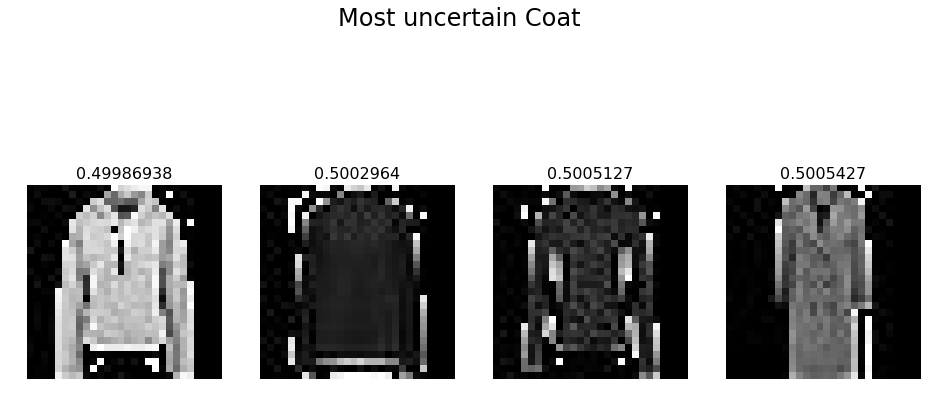

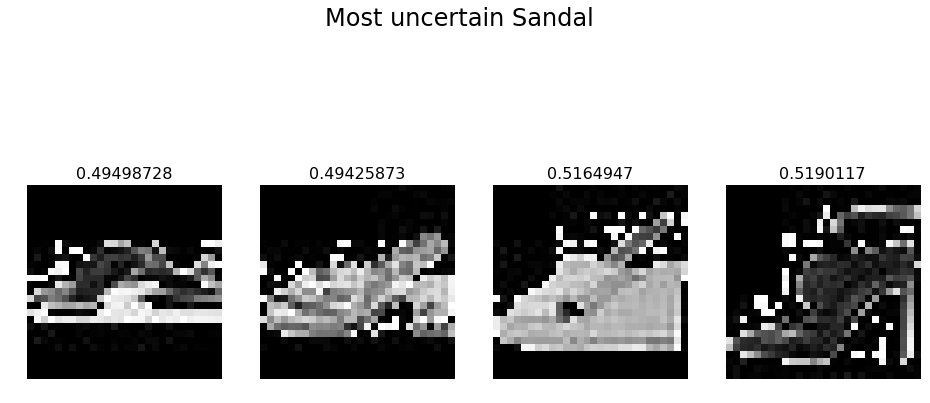

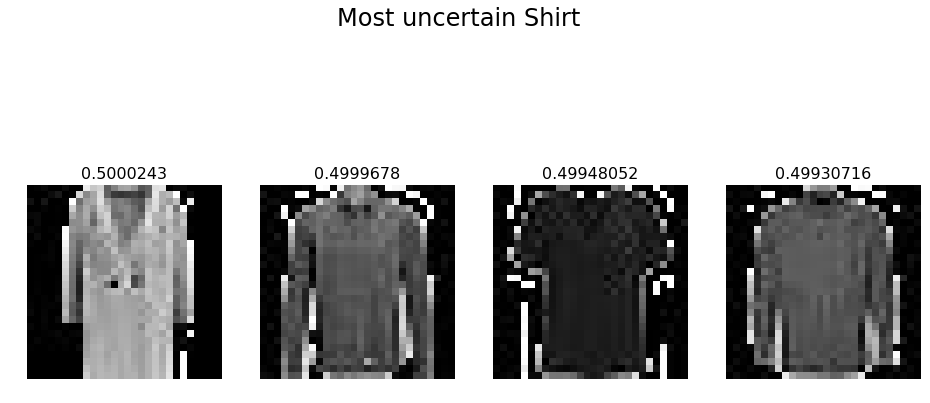

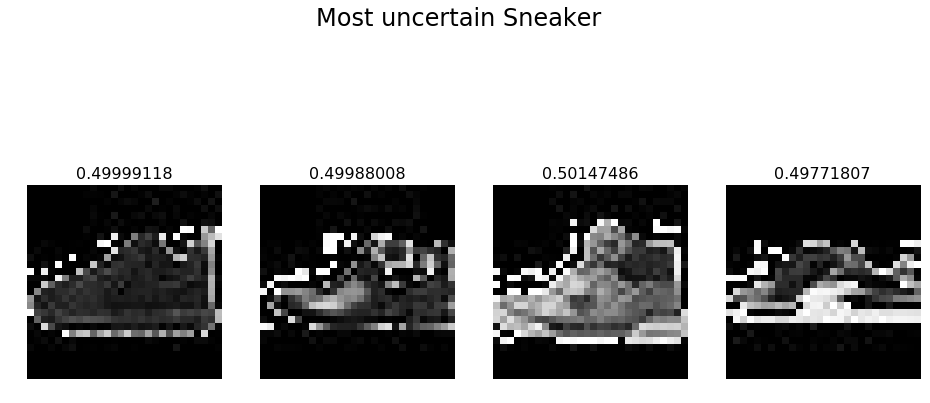

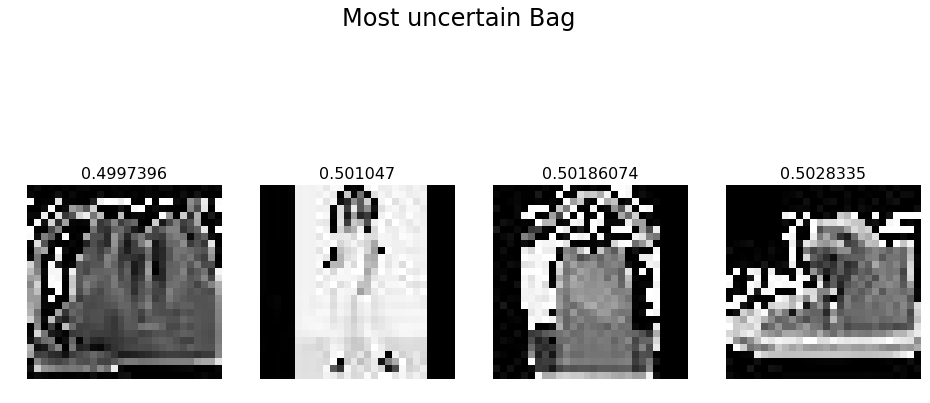

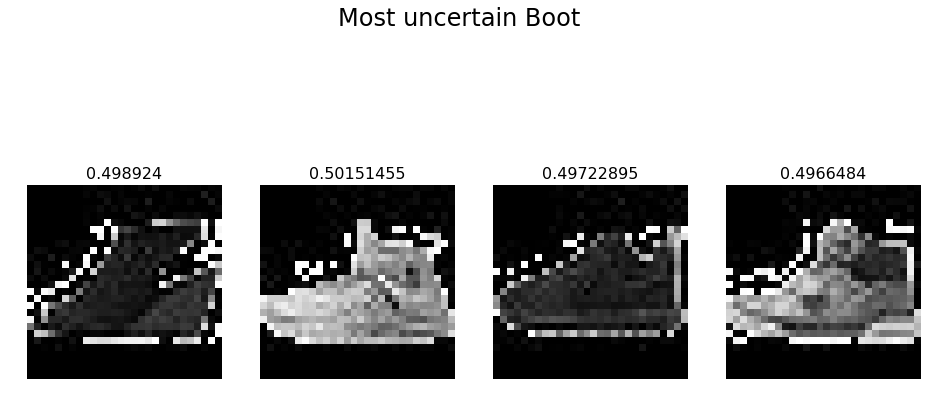

In [35]:
for key, label in labels_dict.items():
    probs = all_probs[key]
    most_uncertain = np.argsort(np.abs(probs-0.5))[:4]
    plot_val_with_title(most_uncertain,
                        "Most uncertain {}".format(label))

## Tuning the Learning Rate

In [36]:
learn = ConvLearner.pretrained(arch, data, precompute=True)


**Finding the best learning rate by increasing it till the loss does not decrease any further**

In [37]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 648/782 [00:30<00:06, 21.59it/s, loss=3.28] 

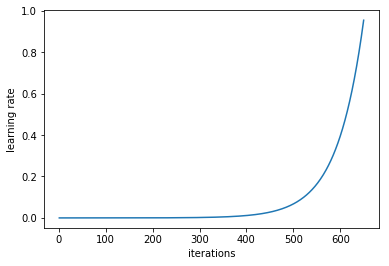

In [38]:
learn.sched.plot_lr()

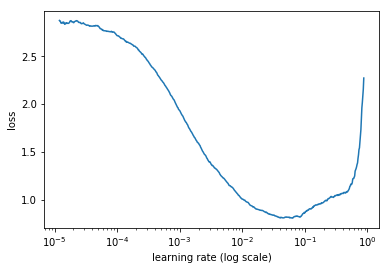

In [39]:
learn.sched.plot()

**We see that the loss stabilises at around 0.1. However, it is still improving at around 0.01.**  

### Learning Rate Experiment: 0.05, 0.001 

In [48]:
lr = 0.05

In [42]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

 50%|█████     | 391/782 [00:09<00:09, 42.96it/s, loss=0.625]

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/amanthevinci/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/amanthevinci/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/amanthevinci/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.561684   0.447371   0.834793  
    1      0.509062   0.4164     0.848627                    



[0.41640002, 0.8486265923566879]

**The accuracy didn't change much. However, we find that the loss was still decreasing. Maybe more epochs are required for it to converge**

In [44]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lr, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.533264   0.456031   0.832205  
    1      0.511457   0.41858    0.848826                    
    2      0.476418   0.401341   0.852309                    



[0.40134063, 0.8523089171974523]

**We see an improvement of 1% in the accuracy with a new epoch. Maybe we can try more.**

In [49]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lr, 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.563212   0.44973    0.83758   
    1      0.496929   0.415596   0.84992                     
    2      0.472383   0.409247   0.852607                    
    3      0.440639   0.387531   0.854399                    



[0.38753062, 0.8543988853503185]

**We see no significant improvement by adding another epoch of training.**

In [46]:
lr = 0.001

In [47]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(lr, 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.767021   0.589015   0.798069  
    1      0.659202   0.526268   0.811803                    
    2      0.623955   0.496948   0.821756                    
    3      0.575266   0.481673   0.827926                    



[0.48167282, 0.8279259554140127]

**The model accuracy worsens on lowering the learning rate. Hence, 0.05 seems to be the optimal learning rate.**

### Most Optimal Learning Rate: 0.05 [3 Epochs]
